In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from moviepy.editor import *
from scipy import misc
import pickle
from glob import glob #glob (short for global) is used to return all file paths that match a specific pattern
%matplotlib inline

In [2]:
#Creating Object points for Camera Callibration. 6*9 taken.  
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [3]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

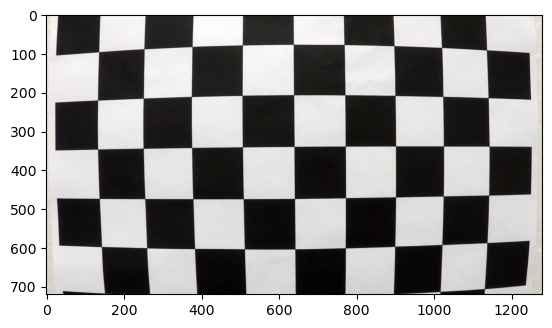

In [4]:
image1 = plt.imread('camera_cal/calibration1.jpg')
plt.imshow(image1)
plt.show()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,30,0.001)

In [5]:
for i , name in enumerate(glob("camera_cal/calibration*.jpg")):
    img = plt.imread(name)
    gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (9,6),None)
    if ret == True :
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

In [6]:
img2 = cv.imread('camera_cal/calibration1.jpg')
img_size = (img2.shape[1], img2.shape[0])

In [7]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [8]:
def undistort(img):
    return cv.undistort(img, mtx, dist, None, mtx)
und = undistort(img2)

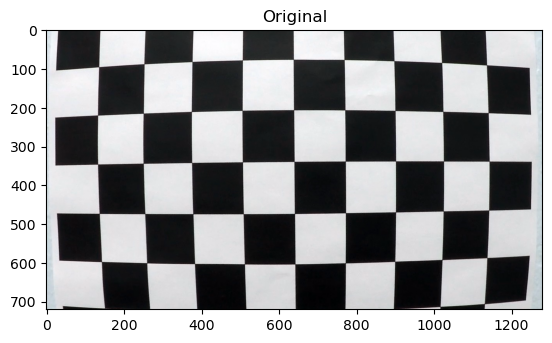

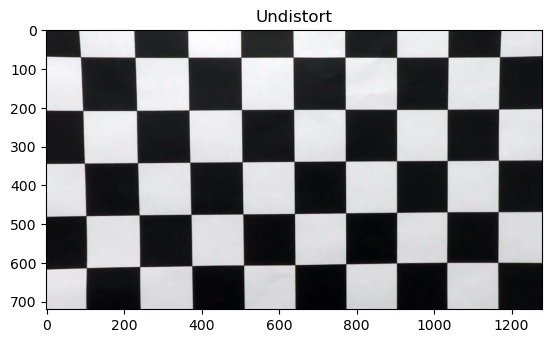

In [9]:
plt.imshow(img2)
plt.title('Original')
plt.show()
plt.imshow(und)
plt.title('Undistort')
plt.show()

In [10]:
def cameracalibrate():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    image1 = plt.imread('camera_cal/calibration1.jpg')
    #plt.imshow(image1)
    #plt.show()
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    for i , name in enumerate(glob("camera_cal/calibration*.jpg")):
    #img = plt.imread(name)
        gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
        ret, corners = cv.findChessboardCorners(gray, (9,6),None)
        if ret == True :
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret,mtx,dist,rvecs,tvecs

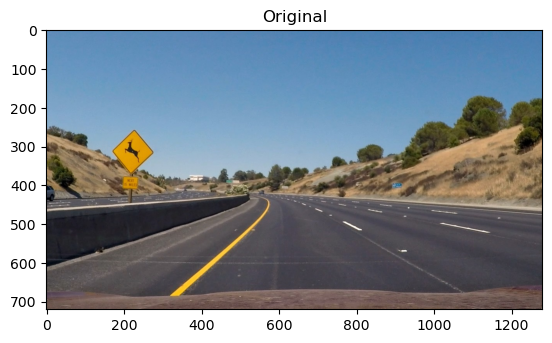

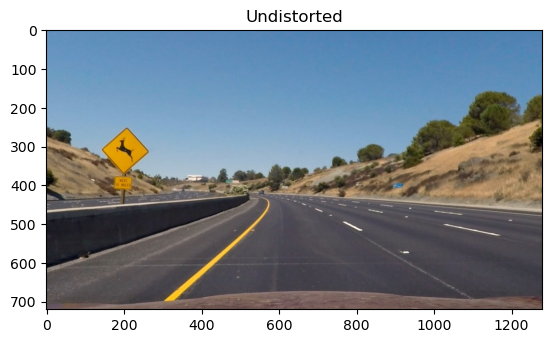

In [11]:
ex = plt.imread("test_images/test2.jpg")
plt.imshow(ex)
plt.title("Original")
plt.show()
und = undistort(ex)
plt.imshow(und)
plt.title("Undistorted")
plt.show()

In [12]:
src = np.float32([[580, 460],[700, 460],[1040, 680],[260, 680],])

In [13]:
dst = np.float32([[260, 0],[1040, 0],[1040, 720],[260, 720],])

In [14]:
def warp(img):
    src = np.float32([[580, 460],[700, 460],[1040, 680],[260, 680]])
    dst = np.float32([[260, 0],[1040, 0],[1040, 720],[260, 720]])
    M = cv.getPerspectiveTransform(src,dst)
    minv = cv.getPerspectiveTransform(dst,src)
    warp = cv.warpPerspective(img , M ,(img.shape[1],img.shape[0]),flags = cv.INTER_AREA)
    unwarp = cv.warpPerspective(img , minv ,(img.shape[1],img.shape[0]),flags = cv.INTER_AREA)
    return M,minv,warp,unwarp

In [15]:
M , minv , warpim , unwarpim = warp(ex)

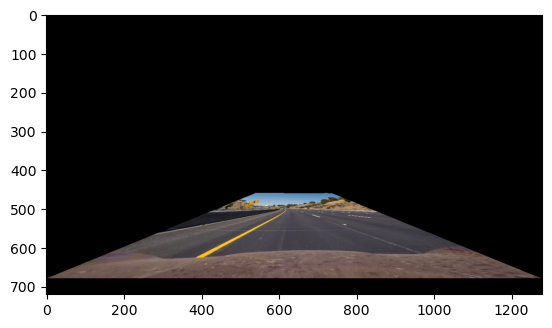

In [16]:
plt.imshow(unwarpim)
plt.show()

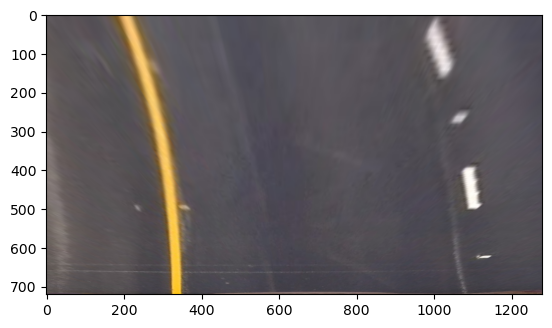

In [17]:
plt.imshow(warpim)
plt.show()

In [18]:
def sobel(img):
    sobelx = cv.Sobel(img[:,:,2],cv.CV_64F,1,0,ksize = 15)
    sobely = cv.Sobel(img[:,:,2],cv.CV_64F,0,1,ksize = 15)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    scaled = np.arctan2(abs_sobelx,abs_sobely)
    sxbinary = np.zeros_like(scaled)
    sxbinary[(scaled>=0.7)&(scaled<=1.2)]=1
    grad = np.sqrt(sobelx**2 + sobely**2)
    scalefac = np.max(grad)/255
    grad = (grad/scalefac).astype(np.uint8)
    binary_output = np.zeros_like(grad)
    binary_output[(grad<=255)&(grad>=55)]=1
    img = cv.cvtColor(img,cv.COLOR_RGB2HSV)
    yellow_min = np.array([15, 100, 120], np.uint8)
    yellow_max = np.array([80, 255, 255], np.uint8)
    yellow_mask = cv.inRange(img, yellow_min, yellow_max)
    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 30, 255], np.uint8)
    white_mask = cv.inRange(img, white_min, white_max)
    color_output = np.zeros_like(img[:,:,0])
    color_output[((yellow_mask != 0) | (white_mask != 0))] = 1
    combined = np.zeros_like(sxbinary)
    combined[((color_output == 1) & ((binary_output == 1) | (sxbinary == 1)))] = 1
    return combined

In [19]:
def polyfit_sliding(img):
    
    histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
    out_img = np.dstack((img, img, img)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(img.shape[0] / nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [20]:
def polyfit_sliding(img):
    
    histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
    out_img = np.dstack((img, img, img)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(img.shape[0] / nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [21]:
def measure_curvature(img,left_fit,right_fit):
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
    leftx = np.array([200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                          for y in ploty])
    rightx = np.array([900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                       for y in ploty])
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    y_eval = np.max(ploty)
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    ratio = left_curverad / right_curverad
    if ratio < 0.66 or ratio > 1.5:
        print('.'.format(ratio))
    lane_leftx = left_fit[0] * (img.shape[0] - 1) ** 2 + left_fit[1] * (img.shape[0] - 1) + left_fit[2]
    lane_rightx = right_fit[0] * (img.shape[0] - 1) ** 2 + right_fit[1] * (img.shape[0] - 1) + right_fit[2]
    car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix
    return (left_curverad + right_curverad) / 2, car_pos.round(2)

In [22]:
def polydrawer(img,left_fit,right_fit,minv):
    warp = np.zeros_like(img).astype(np.uint8)
    fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
    pts = np.hstack((pts_left, pts_right))    
    pts = np.array(pts, dtype=np.int32)
    cv.fillPoly(warp, pts, (0,0,255))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv.warpPerspective(warp, minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
    return cv.addWeighted(img, 1, newwarp, 0.3, 0) 

In [23]:
def pipeline(img):
#     ret, mtx, dist, rvecs, tvecs = cameracalibrate()
    undistort1 = undistort(img)
    img = sobel(undistort1)
    M,minv,warp1,unwarp1=warp(img)
    left_fit,right_fit = polyfit_sliding(warp1)
    img = polydrawer(undistort1,left_fit,right_fit,minv)
    lane_curve, car_pos = measure_curvature(img,left_fit,right_fit)
    if car_pos > 0:
        car_pos_text = '{}m right of center'.format(car_pos)
    else:
        car_pos_text = '{}m left of center'.format(abs(car_pos))
    cv.putText(img, "Lane curve: {}m".format(lane_curve.round()), (10, 50), cv.FONT_HERSHEY_SIMPLEX, 1,color=(255, 255, 255), thickness=2)
    cv.putText(img, "Car is {}".format(car_pos_text), (10, 100), cv.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255),thickness=2)
    return img

In [24]:
video = 'project_video'
white_output = '{}_done_2.mp4'.format(video)
clip1 = VideoFileClip('{}.mp4'.format(video))
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_video_done_2.mp4.
Moviepy - Writing video project_video_done_2.mp4



t:   5%|███▌                                                               | 68/1260 [00:15<04:39,  4.27it/s, now=None]

.


t:  27%|█████████████████▉                                                | 342/1260 [01:21<03:29,  4.37it/s, now=None]

.


t:  38%|█████████████████████████▎                                        | 484/1260 [01:55<03:06,  4.15it/s, now=None]

.


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [03:05<02:02,  3.86it/s, now=None]

.


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [03:16<01:38,  4.31it/s, now=None]

.


Moviepy - Done !
Moviepy - video ready project_video_done_2.mp4


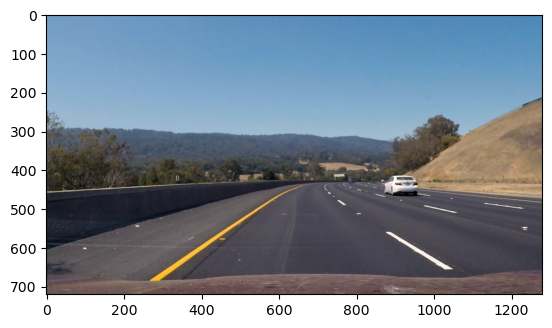

In [25]:
plt.imshow(plt.imread('test_images/test3.jpg'))

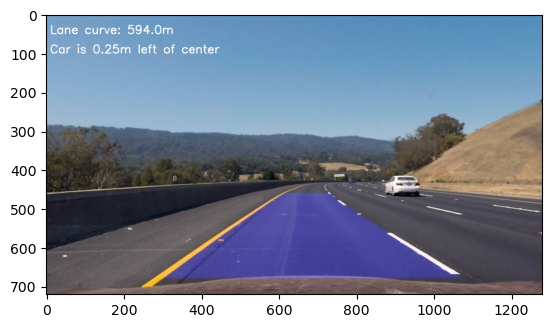

In [26]:
plt.imshow(pipeline(plt.imread('test_images/test3.jpg')))

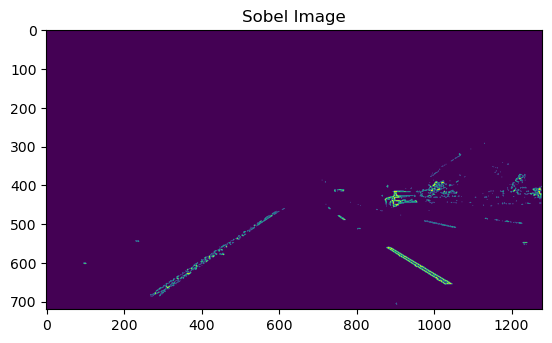

In [27]:
im1 = plt.imshow(sobel(plt.imread('test_images/test3.jpg')))
plt.title("Sobel Image")
im1 = plt.imread("test_images/test3.jpg")
im1 = sobel(im1)

In [28]:
m , minv3 , warp , unwarp = warp(im1)

Text(0.5, 1.0, 'Warped Sobel Image')

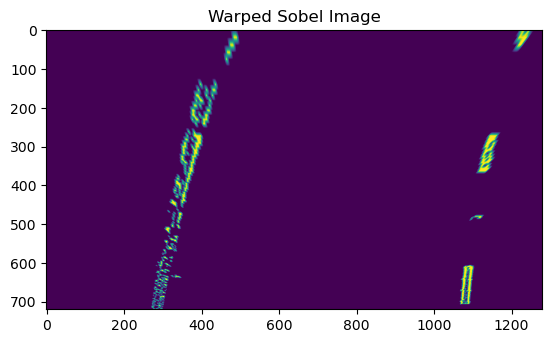

In [29]:
plt.imshow(warp)
plt.title("Warped Sobel Image")

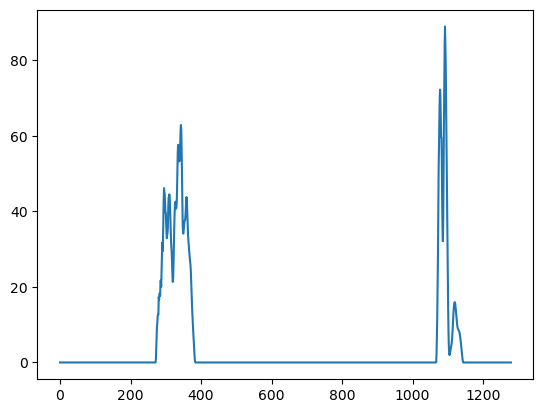

In [30]:
histogram = np.sum(warp[int(warp.shape[0] / 2):, :], axis=0)
plt.plot(histogram)

In [31]:
capture = cv.VideoCapture('project_video_done_2.mp4')
while True:
    isTrue, frame = capture.read()
    cv.imshow('Output', frame)
    
    if cv.waitKey(20) and 0xFF==ord('d'):
        break

capture.release()
cv.destroyAllWindows()
cv.waitKey(0)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
